<a href="https://colab.research.google.com/github/Dhavalkumar510/Uptrail/blob/main/Week_3_CPSWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-------------------
# Importing Libraries
-------------------

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, r2_score, mean_squared_error
)

# Set visualization style
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 5)


-------------------
# Loading and Exploring the Data
-------------------

DATA INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB
None

SUMMA

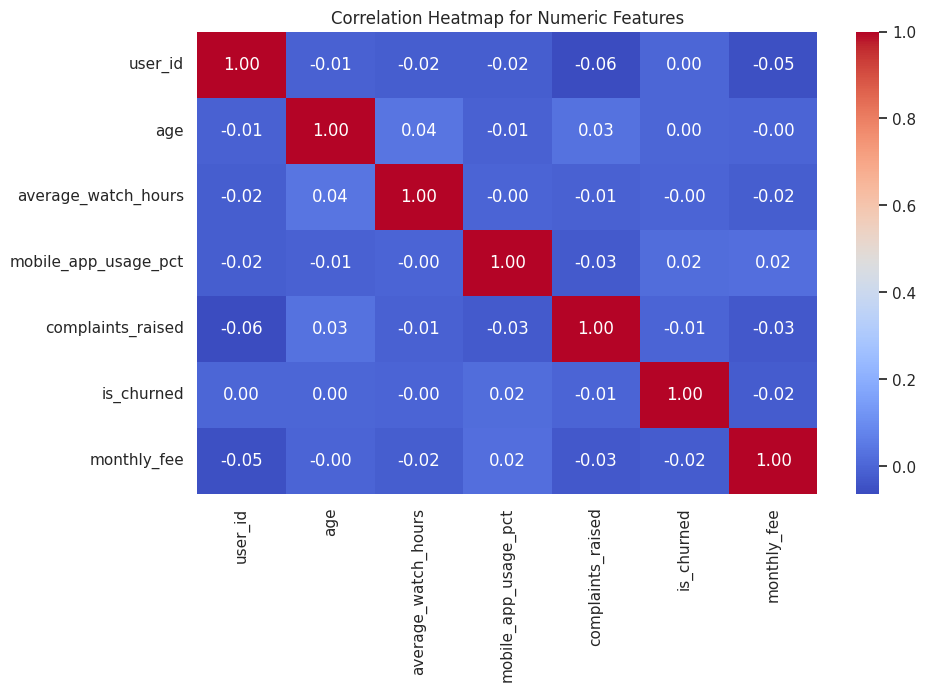

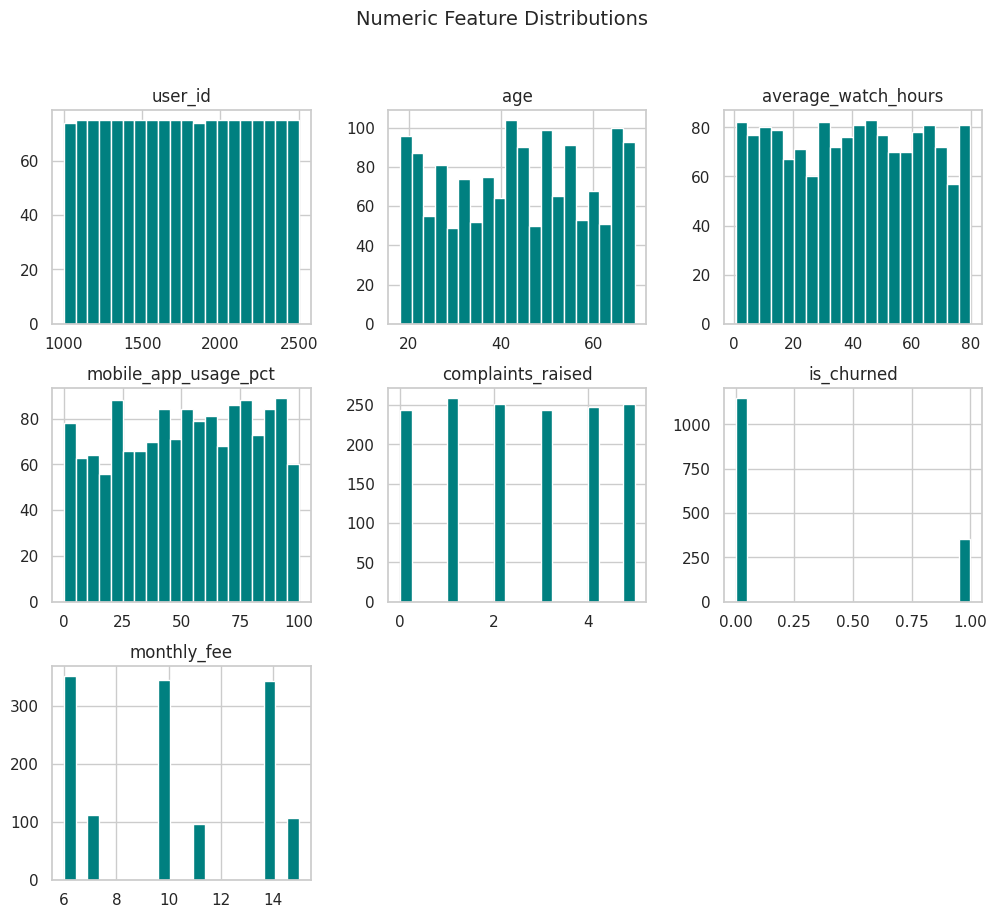

In [21]:
# Load dataset
df = pd.read_csv("/content/streamworks_user_data.csv")

# Basic info
print("DATA INFO:\n")
print(df.info())

# Summary statistics
print("\nSUMMARY STATISTICS:\n", df.describe())

# Value counts (churn variable)
if 'is_churned' in df.columns:
    print("\nChurn Distribution:\n", df['is_churned'].value_counts())

# Missing values
print("\nMISSING VALUES:\n", df.isnull().sum())

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

# Distribution plots
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols].hist(bins=20, figsize=(12,10), color='teal')
plt.suptitle("Numeric Feature Distributions", fontsize=14)
plt.show()


--------------
# Data Cleaning & Feature Engineering
--------------

✅ Data cleaned successfully. Shape: (1500, 24)


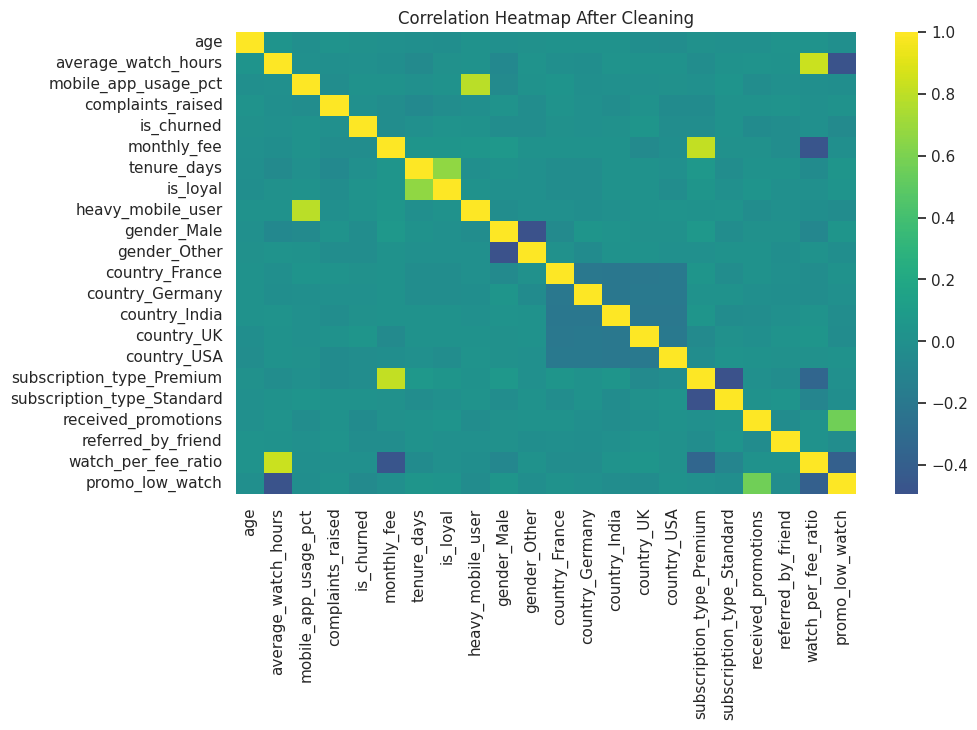

In [46]:
# Convert dates
df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')
df['last_active_date'] = pd.to_datetime(df['last_active_date'], errors='coerce')

# Create new features
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days
df['is_loyal'] = (df['tenure_days'] > 180).astype(int)

# Derived metrics
df['watch_per_fee_ratio'] = df['average_watch_hours'] / df['monthly_fee']
df['heavy_mobile_user'] = (df['mobile_app_usage_pct'] > 70).astype(int)

# Fill missing values
df = df.fillna(df.median(numeric_only=True))
for col in df.select_dtypes('object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical columns
df = pd.get_dummies(df, drop_first=True)

# ✅ Rename columns to remove "_yes" suffix
df.columns = df.columns.str.replace('_yes$', '', regex=True, case=False)

# Drop potential IDs
for col in ['user_id', 'name', 'email']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

print("✅ Data cleaned successfully. Shape:", df.shape)

# Visualize correlation again
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', center=0)
plt.title("Correlation Heatmap After Cleaning")
plt.show()


In [47]:
df.columns.tolist()

['age',
 'signup_date',
 'last_active_date',
 'average_watch_hours',
 'mobile_app_usage_pct',
 'complaints_raised',
 'is_churned',
 'monthly_fee',
 'tenure_days',
 'is_loyal',
 'heavy_mobile_user',
 'gender_Male',
 'gender_Other',
 'country_France',
 'country_Germany',
 'country_India',
 'country_UK',
 'country_USA',
 'subscription_type_Premium',
 'subscription_type_Standard',
 'received_promotions',
 'referred_by_friend',
 'watch_per_fee_ratio',
 'promo_low_watch']

In [32]:
# Example interaction features
df['promo_low_watch'] = ((df['received_promotions'] == 1) &
                         (df['average_watch_hours'] < df['average_watch_hours'].median())).astype(int)

print("Feature Engineering Done.")
print("Columns:", df.columns.tolist())


Feature Engineering Done.
Columns: ['age', 'signup_date', 'last_active_date', 'average_watch_hours', 'mobile_app_usage_pct', 'complaints_raised', 'is_churned', 'monthly_fee', 'tenure_days', 'is_loyal', 'heavy_mobile_user', 'gender_Male', 'gender_Other', 'country_France', 'country_Germany', 'country_India', 'country_UK', 'country_USA', 'subscription_type_Premium', 'subscription_type_Standard', 'received_promotions', 'referred_by_friend', 'watch_per_fee_ratio', 'promo_low_watch']


--------------------
# Statistical Analysis & Insights
--------------------

received_promotions vs Churn → p=0.1058 | Not Significant
referred_by_friend vs Churn → p=0.3818 | Not Significant

T-Test Watch Time: p-value=0.8516 | Not Significant


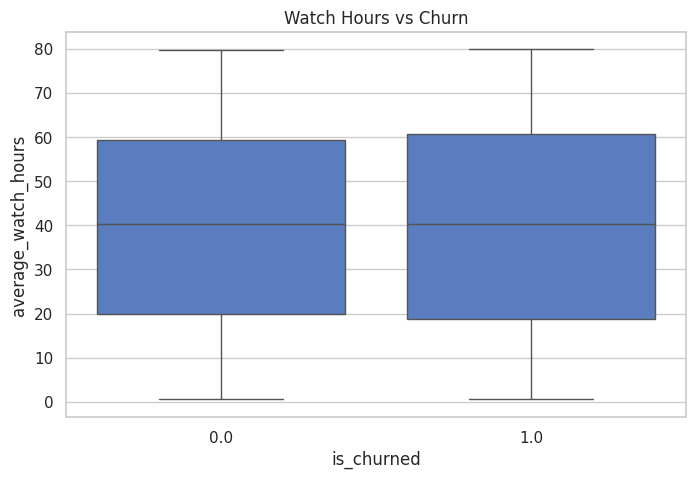

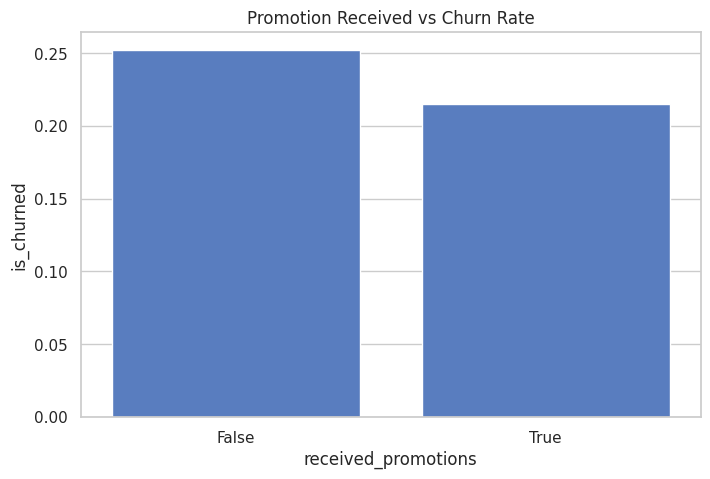

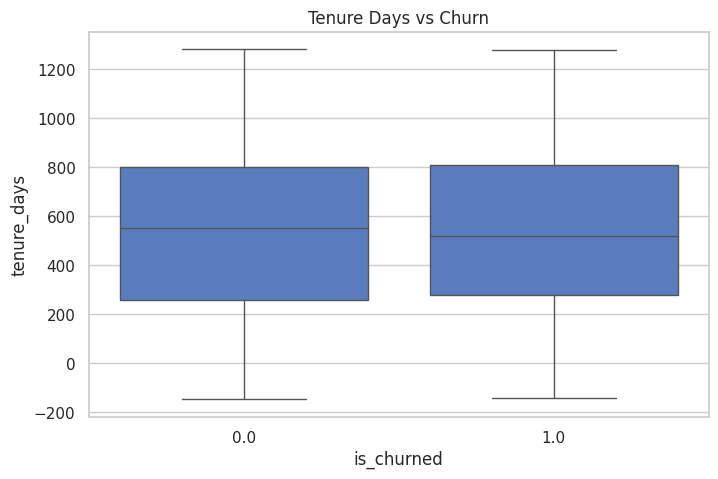

In [33]:
# Chi-square relationships
def chi_square(var):
    table = pd.crosstab(df[var], df['is_churned'])
    chi2, p, dof, exp = chi2_contingency(table)
    print(f"{var} vs Churn → p={p:.4f} |", "Significant" if p < 0.05 else "Not Significant")

for var in ['gender', 'received_promotions', 'referred_by_friend']:
    if var in df.columns:
        chi_square(var)

# T-test: watch time difference
churned = df[df['is_churned'] == 1]['average_watch_hours']
retained = df[df['is_churned'] == 0]['average_watch_hours']
t_stat, p_val = ttest_ind(churned, retained)
print(f"\nT-Test Watch Time: p-value={p_val:.4f} |", "Significant" if p_val < 0.05 else "Not Significant")

# Boxplot: watch hours vs churn
sns.boxplot(x='is_churned', y='average_watch_hours', data=df)
plt.title("Watch Hours vs Churn")
plt.show()

# Bar chart: Promotions vs churn
if 'received_promotions' in df.columns:
    promo_plot = df.groupby('received_promotions')['is_churned'].mean().reset_index()
    sns.barplot(x='received_promotions', y='is_churned', data=promo_plot)
    plt.title("Promotion Received vs Churn Rate")
    plt.show()

# Boxplot for tenure days
sns.boxplot(x='is_churned', y='tenure_days', data=df)
plt.title("Tenure Days vs Churn")
plt.show()


--------------------
# Logistic Regression (Churn Prediction)
--------------------

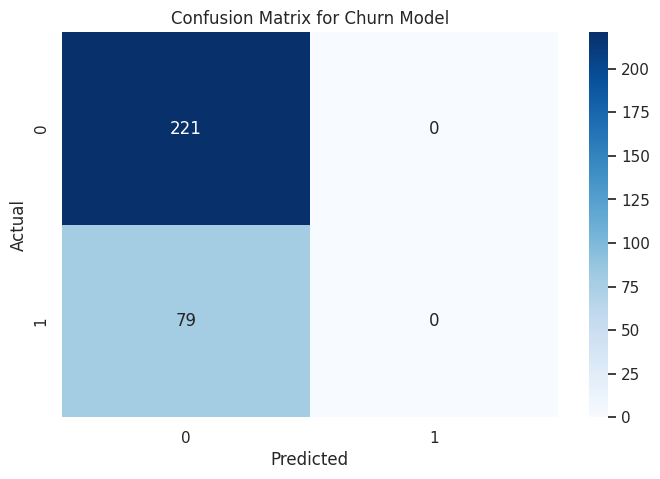


Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      1.00      0.85       221
         1.0       0.00      0.00      0.00        79

    accuracy                           0.74       300
   macro avg       0.37      0.50      0.42       300
weighted avg       0.54      0.74      0.62       300

ROC-AUC Score: 0.5067873303167421


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


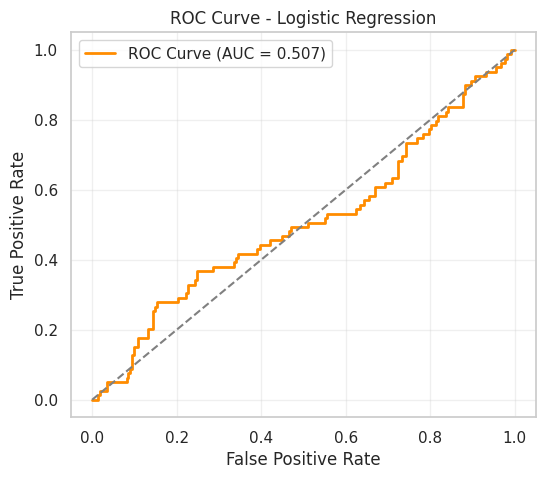

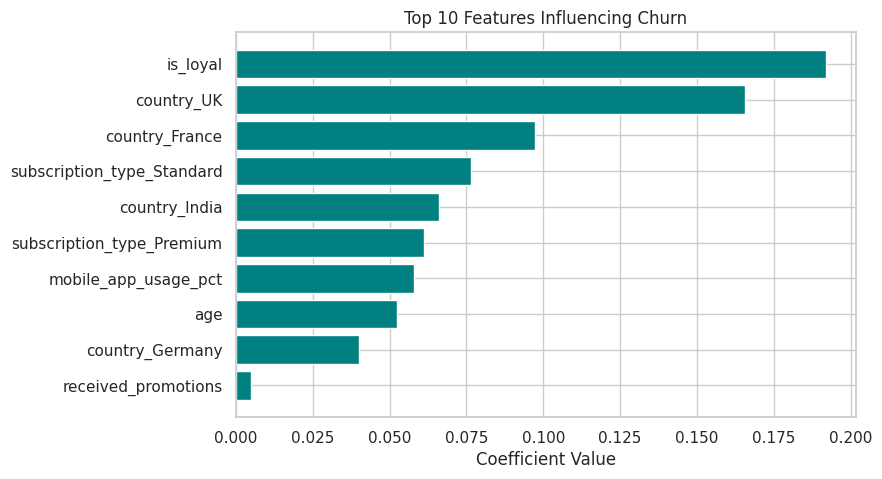

In [37]:
# Split features/target
X = df.drop(['is_churned', 'signup_date', 'last_active_date'], axis=1)
y = df['is_churned']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

# Evaluation
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Churn Model")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# ROC curve with AUC value on graph
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()

# Feature importance plot
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10], color='teal')
plt.title("Top 10 Features Influencing Churn")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.show()

---------------------------------------
# Linear Regression (Predicting Watch Time or Tenure)
---------------------------------------

Linear Regression: R²=0.900, RMSE=7.312


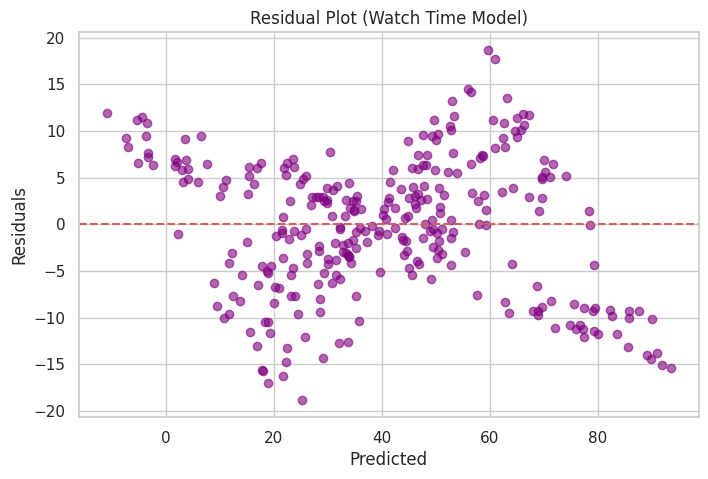

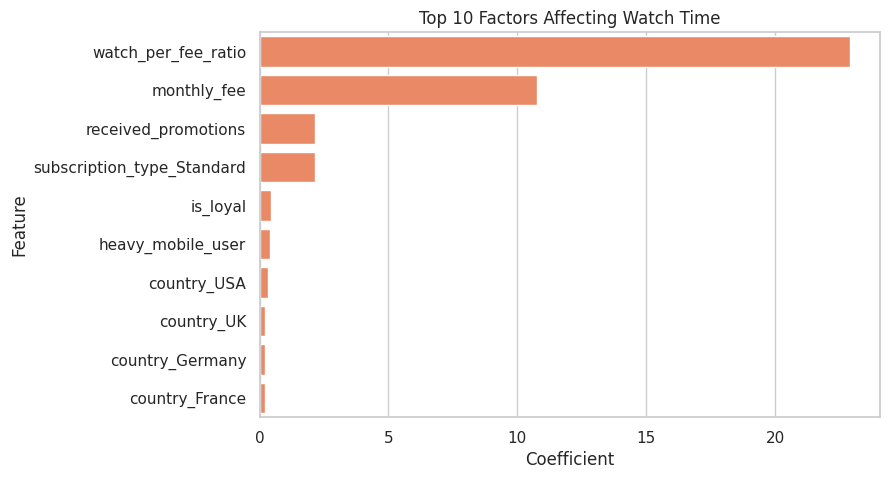

In [39]:
# Predicting average_watch_hours
target = 'average_watch_hours'
features = df.drop(columns=[target, 'is_churned', 'signup_date', 'last_active_date'], errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression: R²={r2:.3f}, RMSE={rmse:.3f}")

# Residual plot
plt.scatter(y_pred, y_test - y_pred, color='purple', alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residual Plot (Watch Time Model)")
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.show()

# Coefficient plot
coef_lin = pd.DataFrame({'Feature': features.columns, 'Coefficient': lin_reg.coef_})
coef_lin = coef_lin.sort_values(by='Coefficient', ascending=False).head(10)

sns.barplot(x='Coefficient', y='Feature', data=coef_lin, color='coral')
plt.title("Top 10 Factors Affecting Watch Time")
plt.show()

------------------------------
#Business Question Summary & Visual Insights
------------------------------

Answer for Question 1: Churn Rate by Promotion Received
 received_promotions
False    0.251958
True     0.215259
Name: is_churned, dtype: float64

 --------------------------------------------------------------------------- 

Answer for Question 2: Correlation between Watch Hours and Churn: -0.005

 --------------------------------------------------------------------------- 

Answer for Question 3: Churn Rate by Mobile-Dominant Users
 heavy_mobile_user
0    0.230694
1    0.241090
Name: is_churned, dtype: float64

 --------------------------------------------------------------------------- 

Answer for Question 4: Top 3 Features Influencing Churn
            Feature  Coefficient
6         is_loyal     0.192138
13      country_UK     0.165697
10  country_France     0.097284

 --------------------------------------------------------------------------- 

Answer for Question 5: Retention Priority: Target users with low watch_per_fee_ratio, low tenure_days, and no promotions.

 -------------

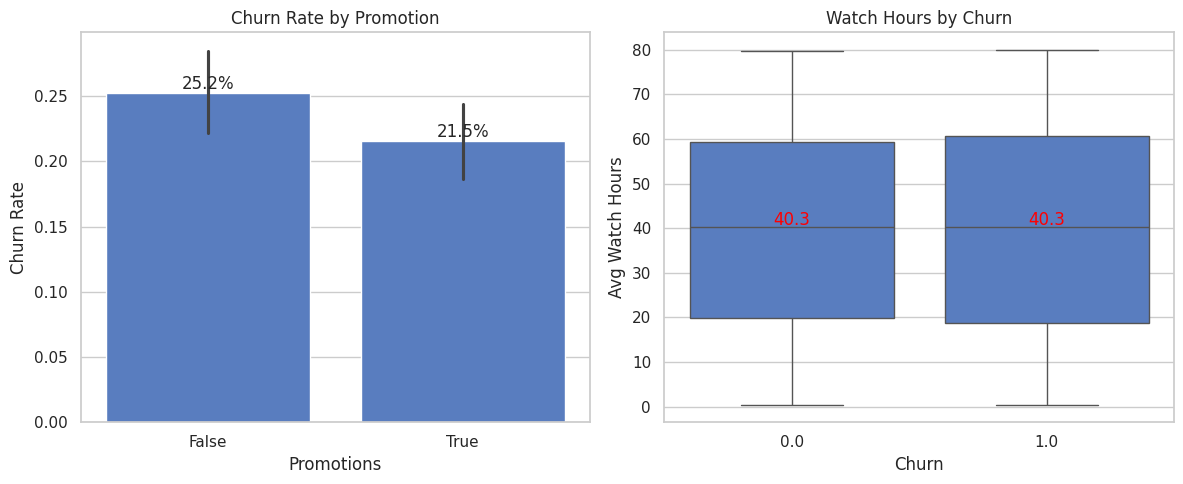

---------------------------------------------------------------------------


In [55]:
# 1️⃣ Promotions vs Churn
if 'received_promotions' in df.columns:
    promo_churn = df.groupby('received_promotions')['is_churned'].mean()
    print("Answer for Question 1: Churn Rate by Promotion Received\n", promo_churn)
print("\n", "-"*75, "\n")

# 2️⃣ Watch time correlation with churn
corr = df['average_watch_hours'].corr(df['is_churned'])
print(f"Answer for Question 2: Correlation between Watch Hours and Churn: {corr:.3f}")
print("\n", "-"*75, "\n")

# 3️⃣ Mobile-dominant user churn
if 'heavy_mobile_user' in df.columns:
    mobile_churn = df.groupby('heavy_mobile_user')['is_churned'].mean()
    print("Answer for Question 3: Churn Rate by Mobile-Dominant Users\n", mobile_churn)
print("\n", "-"*75, "\n")

# 4️⃣ Top churn predictors
print("Answer for Question 4: Top 3 Features Influencing Churn\n", coef_df.head(3))
print("\n", "-"*75, "\n")

# 5️⃣ Retention recommendations
print("Answer for Question 5: Retention Priority: Target users with low watch_per_fee_ratio, "
      "low tenure_days, and no promotions.")
print("\n", "-"*75, "\n")

# 6️⃣ Watch time factors (from linear model)
print("Answer for Question 6: Top Watch Time Predictors\n", coef_lin.head(5))
print("\n", "-"*75, "\n")

# Extra: Visual summary
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Bar plot: Churn rate by promotion
sns.barplot(x='received_promotions', y='is_churned', data=df, ax=axes[0])
axes[0].set(title="Churn Rate by Promotion", xlabel="Promotions", ylabel="Churn Rate")
for p in axes[0].patches:
    axes[0].text(p.get_x()+p.get_width()/2, p.get_height(), f'{p.get_height()*100:.1f}%',
                 ha='center', va='bottom')

# Box plot: Watch hours by churn
sns.boxplot(x='is_churned', y='average_watch_hours', data=df, ax=axes[1])
axes[1].set(title="Watch Hours by Churn", xlabel="Churn", ylabel="Avg Watch Hours")
for i, m in enumerate(df.groupby('is_churned')['average_watch_hours'].median()):
    axes[1].text(i, m+0.5, f'{m:.1f}', ha='center', color='red')

plt.tight_layout()
plt.show()
print("-"*75)
